To begin copy this notebook to your own drive:

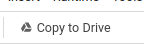


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [ ]:
import gdown
import nltk
# copied the files to personal google drive because failed to load them otherwise
gdown.download('https://drive.google.com/uc?export=download&id=1LOnOcZsUxdEstuY0Ou_XhShFeyfvTJ8J', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=17RLcx6ChIfDzc4Xw39TyYPhEC-so1Iz5', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From: https://drive.google.com/uc?export=download&id=1LOnOcZsUxdEstuY0Ou_XhShFeyfvTJ8J
To: /content/glove.npy

  0%|          | 0.00/480M [00:00<?, ?B/s]
  4%|▍         | 19.4M/480M [00:00<00:02, 192MB/s]
  8%|▊         | 39.8M/480M [00:00<00:02, 199MB/s]
 13%|█▎        | 60.3M/480M [00:00<00:02, 161MB/s]
 16%|█▌        | 77.6M/480M [00:00<00:04, 93.8MB/s]
 20%|██        | 97.5M/480M [00:00<00:03, 116MB/s] 
 23%|██▎       | 113M/480M [00:00<00:03, 120MB/s] 
 27%|██▋       | 127M/480M [00:01<00:02, 118MB/s]
 30%|██▉       | 142M/480M [00:01<00:02, 125MB/s]
 33%|███▎      | 156M/480M [00:01<00:02, 129MB/s]
 35%|███▌      | 170M/480M [00:01<00:02, 131MB/s]
 39%|███▉      | 186M/480M [00:01<00:02, 138MB/s]
 43%|████▎     | 204M/480M [00:01<00:01, 151MB/s]
 46%|████▋     | 223M/480M [00:01<00:01, 159MB/s]
 51%|█████     | 243M/480M [00:01<00:01, 170MB/s]
 54%|█████▍    | 261M/480M [00:01<00:01, 169MB/s]
 58%|█████▊    | 278M/480M [00:02<00:01, 143MB/s]
 61%|██████▏   | 294M/4

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install datasets
!pip install transformers

In [ ]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [ ]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f700cd6f222bd13f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-1deaf0e4869059b7.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b23cfeb68a931a8d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-65e05467bd5c4904.arrow


In [ ]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:
  
  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:
        
      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]
    
    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [ ]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.emb_dim = 300
          self.hidden_dim = 300
          self.drop = nn.Dropout(0.5)
          self.nonLin = nn.LeakyReLU
          self.classifier = nn.Sequential(
              nn.Linear(self.emb_dim, self.hidden_dim),
              self.nonLin(0.1),
              nn.Linear(self.hidden_dim, self.hidden_dim),
              self.nonLin(0.1),
              nn.Linear(self.hidden_dim, self.hidden_dim),
              self.nonLin(0.1),
              nn.Linear(self.hidden_dim, self.num_labels),
              nn.Softmax(dim=1)
          )
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END
          


  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      input_ids_at = input_ids * attention_masks
      embs = self.embeddings(input_ids_at)
      # embs = self.drop(embs)
      avg = torch.mean(embs, 1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=20, #must be at least 10.
                                  per_device_train_batch_size=50,
                                  per_device_eval_batch_size=50,
                                  learning_rate= 0.0005,
                                  # END YOUR END
                                  
                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")
model = DAN()

    

trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE
                  
                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

{'loss': 0.5658, 'learning_rate': 0.000475, 'epoch': 1.0}
{'eval_loss': 0.49890953302383423, 'eval_accuracy': 0.80532, 'eval_runtime': 11.7784, 'eval_samples_per_second': 2122.535, 'eval_steps_per_second': 42.451, 'epoch': 1.0}
{'loss': 0.501, 'learning_rate': 0.00045000000000000004, 'epoch': 2.0}
{'eval_loss': 0.49239128828048706, 'eval_accuracy': 0.81092, 'eval_runtime': 11.7278, 'eval_samples_per_second': 2131.686, 'eval_steps_per_second': 42.634, 'epoch': 2.0}
{'loss': 0.4916, 'learning_rate': 0.000425, 'epoch': 3.0}
{'eval_loss': 0.5049583911895752, 'eval_accuracy': 0.79724, 'eval_runtime': 11.6917, 'eval_samples_per_second': 2138.266, 'eval_steps_per_second': 42.765, 'epoch': 3.0}
{'loss': 0.4845, 'learning_rate': 0.0004, 'epoch': 4.0}
{'eval_loss': 0.5338841080665588, 'eval_accuracy': 0.76816, 'eval_runtime': 11.378, 'eval_samples_per_second': 2197.215, 'eval_steps_per_second': 43.944, 'epoch': 4.0}
{'loss': 0.4887, 'learning_rate': 0.000375, 'epoch': 5.0}
{'eval_loss': 0.481903

TrainOutput(global_step=10000, training_loss=0.4768187194824219, metrics={'train_runtime': 511.0633, 'train_samples_per_second': 978.352, 'train_steps_per_second': 19.567, 'train_loss': 0.4768187194824219, 'epoch': 20.0})

In [ ]:
x = range(1, 21)
y = [trainer.state.log_history[i]['eval_accuracy'] for i in range(1, 41, 2)]

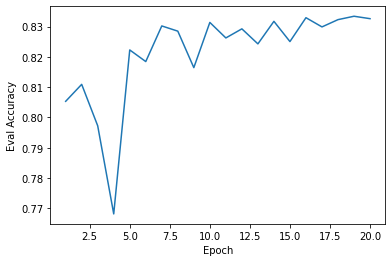

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x,y)
plt.xlabel("Epoch")
plt.ylabel("Eval Accuracy")
plt.show()

In [ ]:
preds, labs, mats = trainer.predict(small_eval_dataset)

In [ ]:
preds = torch.tensor(preds)

In [ ]:
ex_inds = []
counter = 0

for i in range(len(labs)):
  if (int(torch.argmax(preds[i])) != int(labs[i])):
    ex_inds += [i]
    counter += 1
  if (counter == 5):
    break

In [ ]:
ex_inds

[1, 6, 27, 38, 46]

In [ ]:
for ind in ex_inds:
  print(raw_datasets['test'][ind])

{'text': "Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. All of this is entertaining and competently handled but there is nothing that really blows you away if you've seen your share before.<br /><br />The plot is made interesting by the inclusion of a rabbit, which is clever but hardly profound. Many of the characters are heavily stereotyped -- the angry veterans, the terrified illegal aliens, the crooked cops, the indifferent feds, the bitchy tough lady station head, the crooked politician, the fat federale who looks like he was typecast as the Mexican in a Hollywood movie from the 1940s. All passably acted but again nothing special.<br /><br />I thought the main villains were pretty well done and fairly well acted. By the end of the movie you certainly knew who the good guys were and wer